# FairFace 성별 및 나이 동시 분류 모델 (EfficientNet_B0 + PyTorch)

이 노트북은 FairFace 데이터셋을 사용하여 얼굴 이미지를 통해 성별(Gender)과 나이(Age)를 동시에 분류하는 모델을 구축합니다. 모델은 `EfficientNet_B0`을 기반으로 하며 PyTorch로 구현됩니다.

In [69]:
# 1. 라이브러리 불러오기
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# GPU 설정
print("사용 가능한 GPU:", torch.cuda.device_count())
print("GPU 사용 가능 여부:", torch.cuda.is_available())
print("현재 디바이스:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("GPU 이름:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

사용 가능한 GPU: 1
GPU 사용 가능 여부: True
현재 디바이스: cuda
GPU 이름: NVIDIA GeForce RTX 4060 Ti


In [70]:
# 2. 데이터셋 클래스 정의


ImageFile.LOAD_TRUNCATED_IMAGES = True  # 깨진 이미지 로딩 허용

class FairFaceMultiDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

        # 레이블 인코딩 딕셔너리
        self.gender_dict = {'Male': 0, 'Female': 1}
        self.age_dict = {
            '0-2': 0, '3-9': 1, '10-19': 2, '20-29': 3,
            '30-39': 4, '40-49': 5, '50-59': 6, '60-69': 7, 'more than 70': 8
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]
            img_path = os.path.join(self.img_dir, row['file'])
            #print("Loading:", img_path)

            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            gender_label = torch.tensor(self.gender_dict[row['gender']], dtype=torch.long)
            age_label = torch.tensor(self.age_dict[row['age']], dtype=torch.long)

            return image, gender_label, age_label

        except Exception as e:
            print(f"[ERROR] Failed to load image at index {idx} ({row['file']}): {e}")
            # 다음 이미지 재시도 (무한 루프 방지)
            return self.__getitem__((idx + 1) % len(self))


In [71]:
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image

class CLAHETransform:
    def __init__(self):
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = self.clahe.apply(l)
        img = cv2.merge((l, a, b))        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)


In [72]:
# 3. 전처리 및 데이터 분할
train_val_transform = transforms.Compose([
    CLAHETransform(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#c:/TrainTest 폴더 만들고 그안에 데이터와 라벨링된 파일들 넣었음 
df = pd.read_csv("C:/TrainTest/fairface_label_train.csv")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = pd.read_csv('C:/TrainTest/fairface_label_val.csv')

train_dataset = FairFaceMultiDataset(train_df, img_dir="C:/TrainTest/fairface-img-margin025-trainval", transform=train_val_transform)
val_dataset = FairFaceMultiDataset(val_df, img_dir="C:/TrainTest/fairface-img-margin025-trainval", transform=train_val_transform)
test_dataset = FairFaceMultiDataset(test_df, img_dir="C:/TrainTest/fairface-img-margin025-trainval", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

image shape: torch.Size([32, 3, 224, 224])
gender label shape: torch.Size([32])
age label  shape: torch.Size([32])


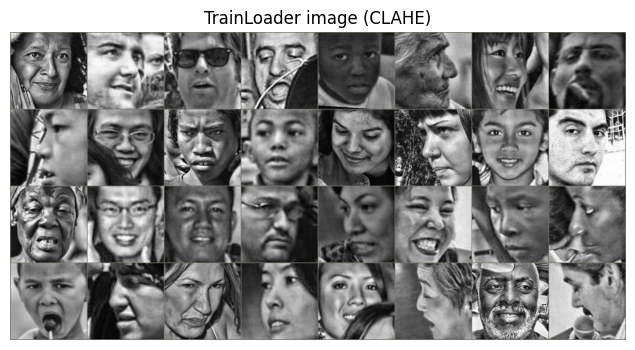

In [84]:
import matplotlib.pyplot as plt
import torchvision

# 배치 하나 꺼내기
images, gender_labels, age_labels = next(iter(train_loader))

print("image shape:", images.shape)
print("gender label shape:", gender_labels.shape)
print("age label  shape:", age_labels.shape)


# 첫 번째 이미지 시각화
img = torchvision.utils.make_grid(images[:])  # 앞에서 4개만 보기
img = img.permute(1, 2, 0)  # CHW -> HWC
img = img.numpy()
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # 역정규화
img = np.clip(img, 0, 1)

plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.title("TrainLoader image (CLAHE)")
plt.axis('off')
plt.show()

In [85]:
# 4. 모델 정의 (EfficientNet_B0 기반 다중 출력)
class MultiTaskEfficientNet(nn.Module):
    def __init__(self):
        super(MultiTaskEfficientNet, self).__init__()
        self.backbone = efficientnet_b0(pretrained=True)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        self.gender_head = nn.Linear(in_features, 2)
        self.age_head = nn.Linear(in_features, 9)

    def forward(self, x):
        features = self.backbone(x)
        gender_out = self.gender_head(features)
        age_out = self.age_head(features)
        return gender_out, age_out



In [86]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [87]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

age_classes = np.unique(train_df['age'])  # age 열이 정수형 클래스여야 함
class_weights = compute_class_weight(class_weight='balanced', classes=age_classes, y=train_df['age'])
age_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [88]:
# 모델 GPU에 할당
model = MultiTaskEfficientNet().to(device)

# 5. 손실 함수, 옵티마이저 정의.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_gender = nn.CrossEntropyLoss()
criterion_age = FocalLoss(gamma=2.0, weight=age_weights)

c:\Users\daewo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daewo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
save_dir = "C:/TrainTest/models"
os.makedirs(save_dir, exist_ok=True)

def train_model(model, train_loader, val_loader, criterion_gender,criterion_age, optimizer, num_epochs=10, save_path=save_dir):
    train_loss_history = []
    gender_acc_history = []
    age_acc_history = []
    val_gender_acc_history = []
    val_age_acc_history = []

    best_val_avg_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_gender = 0
        correct_age = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, gender_labels, age_labels in loop:
            images = images.to(device)
            gender_labels = gender_labels.to(device)
            age_labels = age_labels.to(device)

            optimizer.zero_grad()
            gender_out, age_out = model(images)
            loss_gender = criterion_gender(gender_out, gender_labels)
            loss_age = criterion_age(age_out, age_labels)
            loss = loss_gender + loss_age
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_gender += (gender_out.argmax(1) == gender_labels).sum().item()
            correct_age += (age_out.argmax(1) == age_labels).sum().item()

        train_gender_acc = correct_gender / len(train_loader.dataset)
        train_age_acc = correct_age / len(train_loader.dataset)
        avg_train_loss = train_loss / len(train_loader)

        train_loss_history.append(avg_train_loss)
        gender_acc_history.append(train_gender_acc)
        age_acc_history.append(train_age_acc)

        print(f"\n[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, "
              f"Gender Acc: {train_gender_acc:.4f}, Age Acc: {train_age_acc:.4f}")

        # Validation
        model.eval()
        val_gender_correct = 0
        val_age_correct = 0
        with torch.no_grad():
            for images, gender_labels, age_labels in val_loader:
                images = images.to(device)
                gender_labels = gender_labels.to(device)
                age_labels = age_labels.to(device)

                gender_out, age_out = model(images)
                val_gender_correct += (gender_out.argmax(1) == gender_labels).sum().item()
                val_age_correct += (age_out.argmax(1) == age_labels).sum().item()

        val_gender_acc = val_gender_correct / len(val_loader.dataset)
        val_age_acc = val_age_correct / len(val_loader.dataset)

        val_gender_acc_history.append(val_gender_acc)
        val_age_acc_history.append(val_age_acc)

        print(f"[Validation] Gender Acc: {val_gender_acc:.4f}, Age Acc: {val_age_acc:.4f}\n")

        # Save current epoch model
        torch.save(model.state_dict(), f"{save_path}/epoch_{epoch+1}.pt")

        # Save best model
        val_avg_acc = (val_gender_acc + val_age_acc) / 2
        if val_avg_acc > best_val_avg_acc:
            best_val_avg_acc = val_avg_acc
            torch.save(model.state_dict(), f"{save_path}/best_model.pt")

    # 시각화
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(gender_acc_history, label="Train Gender Acc")
    plt.plot(age_acc_history, label="Train Age Acc")
    plt.plot(val_gender_acc_history, label="Val Gender Acc", linestyle='--')
    plt.plot(val_age_acc_history, label="Val Age Acc", linestyle='--')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [90]:
# 7. 학습 실행
train_model(model, train_loader, val_loader, criterion_gender,criterion_age, optimizer, num_epochs=5)

Epoch 1/5: 100%|██████████| 2169/2169 [05:59<00:00,  6.03it/s]



[Epoch 1] Train Loss: 1.3055, Gender Acc: 0.8215, Age Acc: 0.3978
[Validation] Gender Acc: 0.8919, Age Acc: 0.4483



Epoch 2/5: 100%|██████████| 2169/2169 [05:51<00:00,  6.17it/s]



[Epoch 2] Train Loss: 0.8894, Gender Acc: 0.8922, Age Acc: 0.4670
[Validation] Gender Acc: 0.9030, Age Acc: 0.4611



Epoch 3/5: 100%|██████████| 2169/2169 [06:15<00:00,  5.78it/s]



[Epoch 3] Train Loss: 0.7266, Gender Acc: 0.9128, Age Acc: 0.4981
[Validation] Gender Acc: 0.9068, Age Acc: 0.5005



Epoch 4/5: 100%|██████████| 2169/2169 [09:54<00:00,  3.65it/s]



[Epoch 4] Train Loss: 0.6074, Gender Acc: 0.9254, Age Acc: 0.5248
[Validation] Gender Acc: 0.9118, Age Acc: 0.4955



Epoch 5/5:   7%|▋         | 146/2169 [00:35<08:14,  4.09it/s]


KeyboardInterrupt: 

In [23]:
# 베스트 모델 불러오기
model.load_state_dict(torch.load('C:/TrainTest/models/best_model.pt'))
model.to(device)
model.eval()

# 정확도 측정
gender_correct = 0
age_correct = 0
total = 0

with torch.no_grad():
    for images, gender_labels, age_labels in test_loader:
        images = images.to(device)
        gender_labels = gender_labels.to(device)
        age_labels = age_labels.to(device)

        gender_out, age_out = model(images)

        gender_preds = gender_out.argmax(dim=1)
        age_preds = age_out.argmax(dim=1)

        gender_correct += (gender_preds == gender_labels).sum().item()
        age_correct += (age_preds == age_labels).sum().item()
        total += gender_labels.size(0)  # 또는 age_labels.size(0)

gender_acc = gender_correct / total
age_acc = age_correct / total

print(f"✅ Test Gender Accuracy: {gender_acc:.4f}")
print(f"✅ Test Age Accuracy:    {age_acc:.4f}")



C:\Users\daewo\AppData\Local\Temp\ipykernel_25200\3714060425.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/TrainTest/models/best_m

✅ Test Gender Accuracy: 0.8978
✅ Test Age Accuracy:    0.4860
